# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [179]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 0. Problem Statement

**Problem**: 
1. Whether a customer will respond the offer based on the demographics and offer type? 
2. What are the most important factors affecting customers' response?
<br>


**Strategy**: Building a machine learning model to predict customers' respond. 
<br>
**Metrics**: Use accuracy to measure the performance of models if label distribution is similar 

## 1. Data Exploration / Preprocessing/Visualization

### 1.1 Portfolio Data

In [180]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [181]:
# Create dummies for column channels
channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)

In [182]:
# Create dummies for offer_type
offer_type  = pd.get_dummies(portfolio.offer_type)

In [183]:
# Concatenate dataframe and drop original channels and offer_type columns.
portfolio_clean = pd.concat([portfolio[['id', 'difficulty', 'duration', 'reward']], channels, offer_type], axis = 1)

In [184]:
# rename id to offer_id
portfolio_clean.rename(columns={'id':'offer_id'}, inplace=True)

In [185]:
portfolio_clean

,offer_id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


### 1.2 Profile Data

In [186]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [187]:
profile.shape

(17000, 5)

In [188]:
# Obs with age 118 are related to null value in gender and income.  Let's take a closer look at obs with age 118
profile[profile.age==118][['gender','income']].isnull().all()

gender    True
income    True
dtype: bool

In [189]:
# Check null value exclude obs with age 118
profile[profile.age!=118].isnull().any()

age                 False
became_member_on    False
gender              False
id                  False
income              False
dtype: bool

Age 118 seems a code represent null values in other columns. 2175 users with age 118, the largest user group by age is unnatural. Therefore, obs with age 118 will be dropped.

In [190]:
# drop user with age 118
profile_clean = profile[profile.age!=118].copy()
profile_clean.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [191]:
# Rename id to user_id to avoid confusion with offer_id
profile_clean.rename(columns={'id':'user_id'}, inplace = True)

In [192]:
# Different generation may have different purchasing behabivor. Segment users' age by 10 years
profile_clean['age_gen'] = profile_clean.age.apply(lambda x: int(x/10)*10)

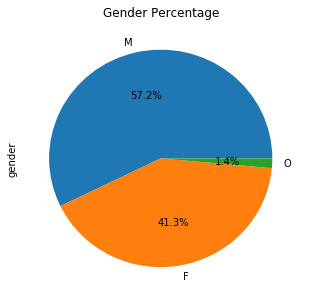

In [283]:
# Plot pie chart for gender percentage
profile_clean.gender.value_counts().plot.pie(figsize=(5, 5), title ='Gender Percentage', autopct='%1.1f%%');

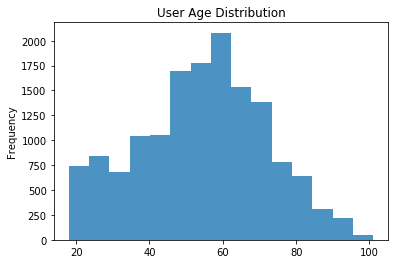

In [284]:
# Plot hisgram for user age
profile_clean.age.plot.hist(bins=15, alpha=0.8, title ='User Age Distribution');

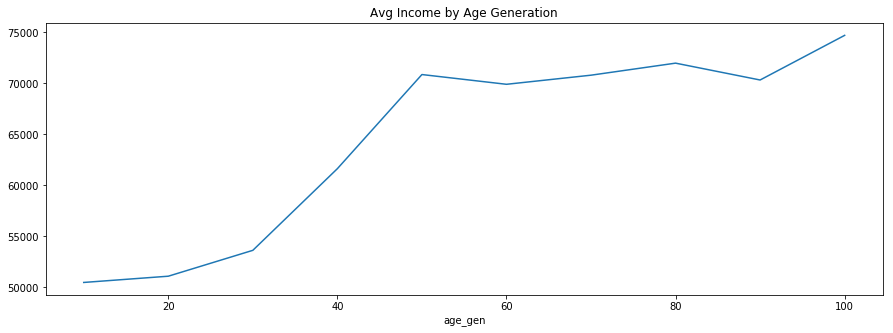

In [285]:
profile_clean.groupby(['age_gen'])['income'].mean().plot.line(title ='Avg Income by Age Generation', figsize=(15, 5));

Average income increases sharply till age 50s and then become relativly stable. It is interesting to know whether higher income users become less sensitive to the offer sent. 

In [196]:
# Convert became_member_on type from int to datetime
profile_clean.became_member_on = pd.to_datetime(profile_clean.became_member_on, format='%Y%m%d')

In [197]:
# Calculate the length of membership relative to the newest member.
profile_clean['member_days']=(profile_clean.became_member_on.max() - profile_clean.became_member_on).dt.days

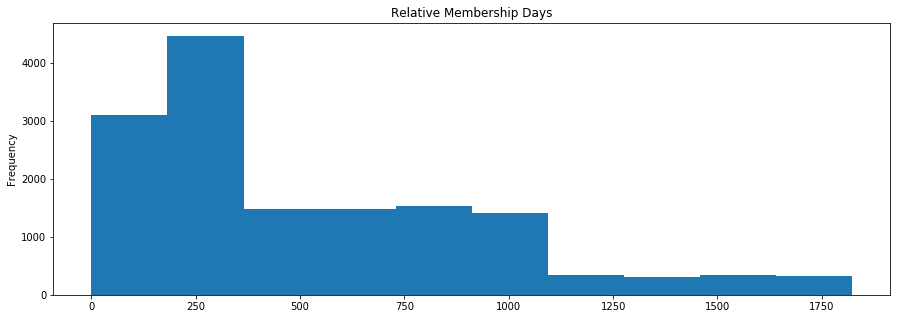

In [198]:
# Plot histgram for membership days
profile_clean.member_days.plot.hist(title='Relative Membership Days',figsize=(15, 5));

More than 7000 users are members less than one years. It's interesting to know whether new members are more likely to respond to the offers.

### 1.3 Transcript Data

In [199]:
# check Transcript data sorted by person and time
transcript.sort_values(by=['person','time']).head()

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}


In [200]:
# Drop people with age 118 as they are excluded in other data
transcript_clean = transcript[~transcript.person.isin(profile[profile.age==118]['id'])].copy()

In [201]:
# Sort data by person and time
transcript_clean.sort_values(by=['person','time'],inplace=True)

In [202]:
transcript_clean.head()

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}


### 1.31 Transcript Offer Data

In [203]:
# Select event related to offer
transcript_offer = transcript_clean[transcript_clean.event!='transaction'].copy()
transcript_offer.head()

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}


In [204]:
# Extract offer_id from column value
transcript_offer['offer_id'] = transcript_offer.value.apply(lambda x: list(x.values())[0])

In [205]:
# Drop column value
transcript_offer.drop(columns='value', inplace=True)

In [206]:
# Sort column by person offer_id and time
transcript_offer.sort_values(by=['person', 'offer_id', 'time'], inplace=True)

In [207]:
# Rename column person to user_id
transcript_offer.rename(columns={'person':'user_id'}, inplace=True)

In [208]:
# encode event by number reflecting the sequence
transcript_offer['event_code'] = transcript_offer.event.map({'offer received':1, 'offer viewed':2, 'offer completed':3})

In [209]:
transcript_offer.head()

,event,user_id,time,offer_id,event_code
247879,offer received,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,1
258884,offer completed,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,3
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,1
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,2
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,1


In [210]:
# Reset Index
transcript_offer.reset_index(inplace=True)

In [211]:
# Create column respond with default value zero
transcript_offer['respond'] = 0

In [212]:
# Identify the reponds which follows the sequence: offer received, offer viewed and offer completed
for i in range(0,transcript_offer.shape[0]-2):
    if transcript_offer.loc[i:i+2,'event_code'].tolist()==[1,2,3]: #find the event code matches the sequence
        transcript_offer.loc[i:i+2,'respond']=1 # set their respond as value 1 
        

In [213]:
# Get dummies for event
transcript_offer = pd.get_dummies(transcript_offer, columns=['event'],prefix='', prefix_sep='')

In [214]:
# Groupby user_id and offer_id
transcript_offer = transcript_offer.groupby(['user_id', 'offer_id'])[['respond', 'offer received', 'offer viewed', 'offer completed']].sum()
# Column respond divided by 3
transcript_offer.respond = transcript_offer.respond/3

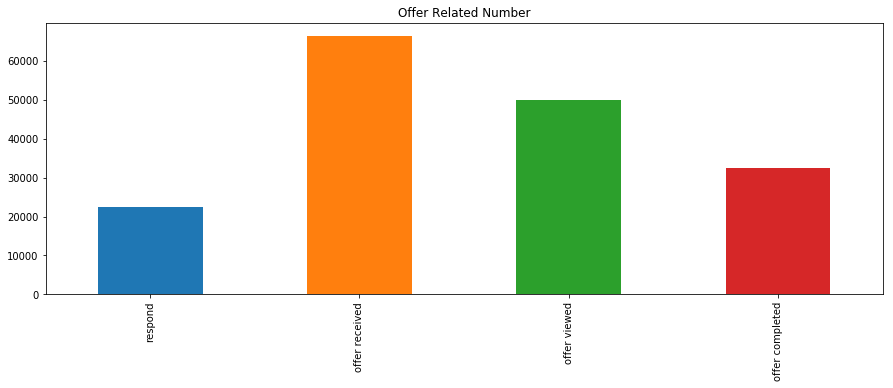

In [215]:
# Take a general look at offer related number
transcript_offer.sum().plot.bar(title="Offer Related Number",figsize=(15, 5));

From the bar chart above, around 1/3 completed offer are not stimulated by the received offer. 

### 1.32 Transcript Transaction Data

In [216]:
# Select transaction event from the transcript dataset
transcript_transaction = transcript_clean[transcript_clean.event=='transaction'].copy()

In [217]:
# Extract value amount 
transcript_transaction.value = transcript_transaction.value.apply(lambda x: list(x.values())[0])

In [218]:
# Rename person to user_id
transcript_transaction.rename(columns={'person':'user_id', 'value':'spending'},inplace=True)

In [219]:
# aggregate the spending by user_id
transcript_transaction = transcript_transaction.groupby('user_id')[['spending']].sum()

In [220]:
# Sort spending descending
transcript_transaction.sort_values('spending',ascending=False, inplace=True)

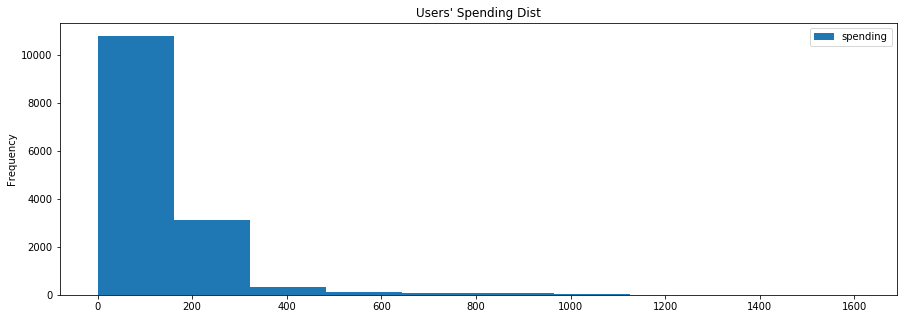

In [221]:
# Plot hist distribution for users' spending amount
transcript_transaction.plot.hist(title='Users\' Spending Dist',figsize=(15, 5));

In [222]:
print('The average amount customers spending is {}.'.format(transcript_transaction.mean().values[0]))

The average amount customers spending is 119.71725089704664.


In [223]:
print('The median amount customers spending is {}.'.format(transcript_transaction.median().values[0]))

The median amount customers spending is 89.86.


### 1.33 Transcript Data Merge

In [224]:
# Merge offer and transaction dataset by user_id
trans_merge = transcript_offer.reset_index().merge(transcript_transaction, how='left', on='user_id')

### 1.4 Merge Three Datasets 

In [225]:
# Merge cleaned portfolio, profile and transcript dataset
df = trans_merge.merge(portfolio_clean, on="offer_id").merge(profile_clean, on='user_id')

In [226]:
# Check null value
df.isnull().sum()

user_id                0
offer_id               0
respond                0
offer received         0
offer viewed           0
offer completed        0
spending            1235
difficulty             0
duration               0
reward                 0
email                  0
mobile                 0
social                 0
web                    0
bogo                   0
discount               0
informational          0
age                    0
became_member_on       0
gender                 0
income                 0
age_gen                0
member_days            0
dtype: int64

In [227]:
# Fill null value in spending with 0 as some customers received offer have no transaction
df.fillna(0, inplace=True)

Some customers will purchase without any offer. We would like to track the spending without any offers by subtracting offer responded spending from the totol spending.

In [228]:
# Create a column offer_spending to track the spending triggered by the completed offer
df['offer_spending']=df.respond*df.difficulty

In [229]:
# Create a column spending wo offer to show non offer related spending
df['spending wo offer'] = df.spending-df.groupby('user_id')['offer_spending'].transform('sum')

In [230]:
# Recode offer_id
df.offer_id = df.offer_id.map(dict(zip(df.offer_id.unique(), range(1,df.offer_id.nunique()+1))))

In [231]:
# Recode offer_id
df.user_id = df.user_id.map(dict(zip(df.user_id.unique(), range(df.user_id.nunique()))))

### 1.41 Offer Performance by Types

In [232]:
# Let's see how much spending is driven by the BOGO and discount offer
print('The percentage of spending driven by BOGO and discount offer is {}.'.format((df.respond * df.difficulty).sum()/(transcript_transaction.sum())[0]))

The percentage of spending driven by BOGO and discount offer is 0.1135455563250976.


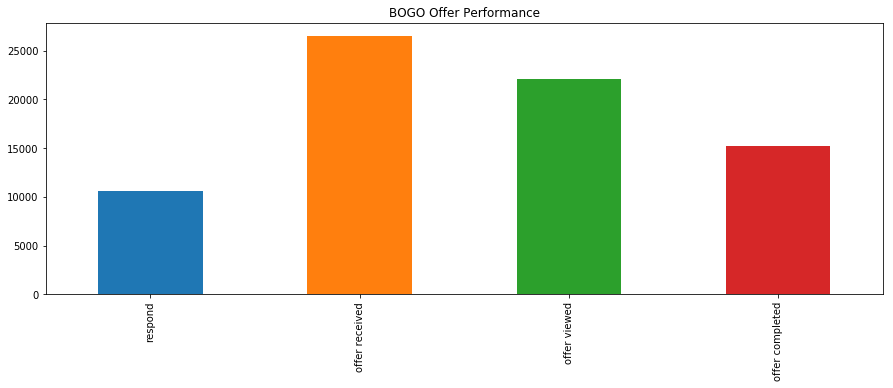

In [233]:
# Plot BOGO Offer performance
df[df.bogo==1][['respond','offer received','offer viewed', 'offer completed']].sum().plot.bar(title='BOGO Offer Performance',figsize=(15, 5));

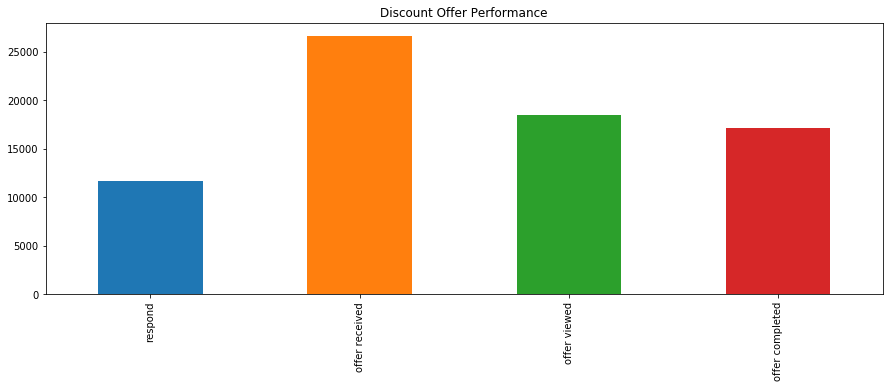

In [234]:
# Plot Discount Offer performance
df[df.discount==1][['respond','offer received','offer viewed', 'offer completed']].sum().plot.bar(title='Discount Offer Performance',figsize=(15, 5));

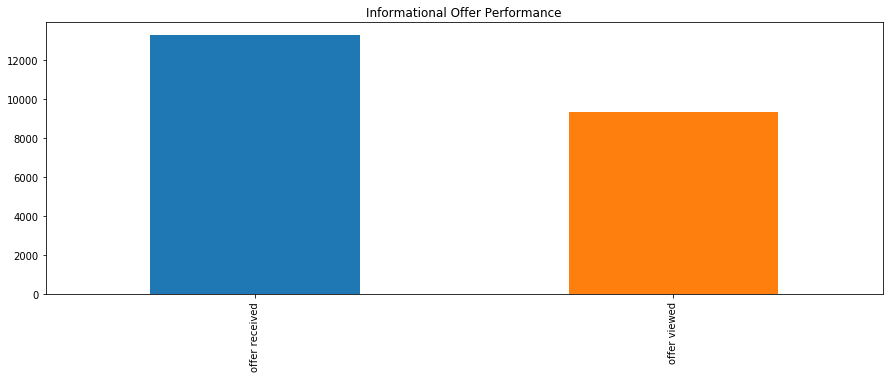

In [235]:
# Plot Info Offer performance
df[df.informational==1][['offer received','offer viewed']].sum().plot.bar(title='Informational Offer Performance',figsize=(15, 5));

In [236]:
# Find offer viewed rate, completed rate and respond rate
offer_rate = df.groupby(['bogo','discount','informational'])[['respond','offer received','offer viewed', 'offer completed']].sum()
offer_rate['event']=['informational', 'discount', 'bogo']

In [237]:
offer_rate.set_index('event', inplace=True)

In [238]:
offer_rate['viewed rate'] = offer_rate['offer viewed']/offer_rate['offer received']
offer_rate['completed rate'] = offer_rate['offer completed']/offer_rate['offer received']
offer_rate['respond rate'] = offer_rate['respond']/offer_rate['offer received']
offer_rate['completed wo respond'] = offer_rate['completed rate']-offer_rate['respond rate']

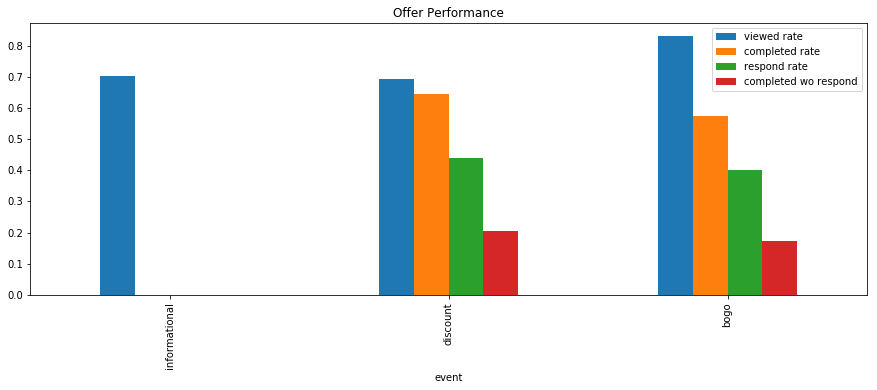

In [239]:
# Take a look at which kind of offer has better performance
offer_rate[['viewed rate', 'completed rate', 'respond rate','completed wo respond']].plot.bar(title='Offer Performance', figsize=(15,5));

Since informational offer doesn't need respond, it can't be compared with other offers. Although discount offer has a lower viewed rate than BOGO offer, it has a higher completed rate and respond rate.

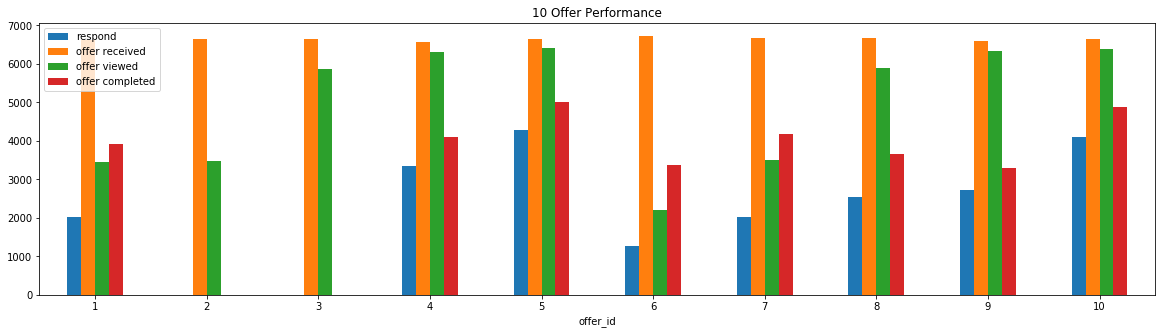

In [287]:
# Take a deeper look at 10 offers' performance
df.groupby(['offer_id'])[['respond','offer received','offer viewed', 'offer completed']].sum().plot.bar(title='10 Offer Performance',figsize=(20,5),rot=0);

For the bar chart above, we can find that around equal number of 10 offers sent to customers. For informational offer, offer 3	has higher viewed rate. Discount offer 5 have highest respond.  Discount offer 6 has the lowest respond number. One possible reason is that it has the highest difficulty. 

In [241]:
# Take a deeper look at 10 offers' performance by their rate
offer10_rate = df.groupby(['offer_id'])[['respond','offer received','offer viewed', 'offer completed']].sum()
offer10_rate['viewed rate'] = offer10_rate['offer viewed']/offer10_rate['offer received']
offer10_rate['completed rate'] = offer10_rate['offer completed']/offer10_rate['offer received']
offer10_rate['respond rate'] = offer10_rate['respond']/offer10_rate['offer received']
offer10_rate['completed wo respond'] = offer10_rate['completed rate']-offer10_rate['respond rate']

offer10_rate

,respond,offer received,offer viewed,offer completed,viewed rate,completed rate,respond rate,completed wo respond
offer_id,,,,,,,,
1,2023.0,6631.0,3460.0,3911.0,0.521792,0.589805,0.305082,0.284723
2,0.0,6657.0,3487.0,0.0,0.523810,0.000000,0.000000,0.000000
3,0.0,6643.0,5873.0,0.0,0.884089,0.000000,0.000000,0.000000
4,3354.0,6576.0,6310.0,4103.0,0.959550,0.623936,0.510036,0.113899
5,4288.0,6652.0,6407.0,5003.0,0.963169,0.752105,0.644618,0.107486
6,1281.0,6726.0,2215.0,3386.0,0.329319,0.503420,0.190455,0.312965
7,2020.0,6685.0,3499.0,4188.0,0.523411,0.626477,0.302169,0.324308
8,2554.0,6683.0,5901.0,3657.0,0.882987,0.547209,0.382164,0.165046
9,2719.0,6593.0,6329.0,3310.0,0.959958,0.502048,0.412407,0.089641


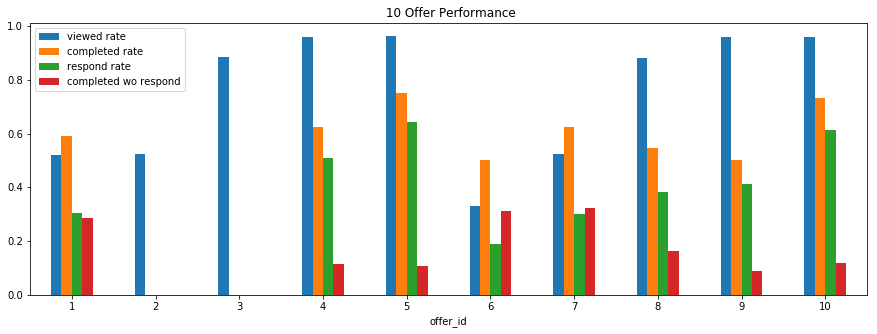

In [242]:
offer10_rate[['viewed rate', 'completed rate', 'respond rate','completed wo respond']].plot.bar(title=' 10 Offer Performance', figsize=(15,5),rot=0);

From rate bar chart above, three offers' completed rates are higher than viewed rate and their completed without respond rate are much higher than other offers. These kind of offers should be avoided sending to customers as they doesn't give enough incentives to customers. 

Since informational offer don't need purchasing to completed the offer, it's hard to know whether this offer boosts customers' spending. One possible way is to comparing the average non offer related spending between customers which received and viewed offer and customers without any informational offer.

In [243]:
# Average spending for customers viewed informational offer
print('Average spending for customers viewed informational offer is ${}.'.format(df[(df.informational==1) & (df['offer viewed']!=0)].groupby('user_id')['spending wo offer'].mean().mean()))

Average spending for customers viewed informational offer is $106.11421619353936.


In [244]:
# Average spending for customers without informational offer
print('Average spending for customers without informational offer is ${}.'.format(df.groupby('user_id').filter(lambda x: x.informational.sum()==0).groupby('user_id')['spending wo offer'].mean().mean()))


Average spending for customers without informational offer is $105.27867615658361.


Difference for average spending between two groups is less than one dollar. It seems that informational offer doesn't stimulate customers if informational offer was sent randomly.

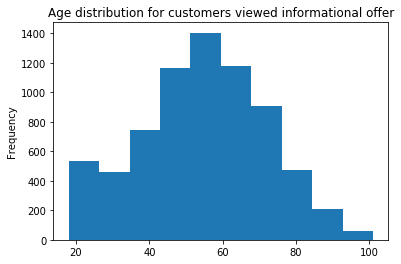

In [245]:
# Check customers' age distribution who viewed the informational offer 
df[(df.informational==1) & (df['offer viewed']!=0)].groupby('user_id').age.mean().plot.hist(title='Age distribution for customers viewed informational offer');

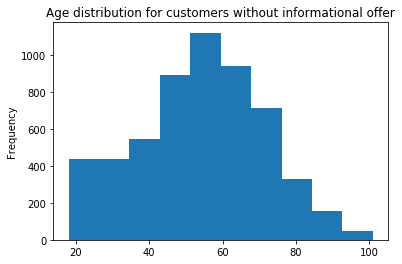

In [246]:
# Check customers' age distribution without received informational offer
df.groupby('user_id').filter(lambda x: x.informational.sum()==0).groupby('user_id').age.mean().plot.hist(title='Age distribution for customers without informational offer');

Two groups have the similar distribution for age.

### 1.5 Offer Performance by Gender

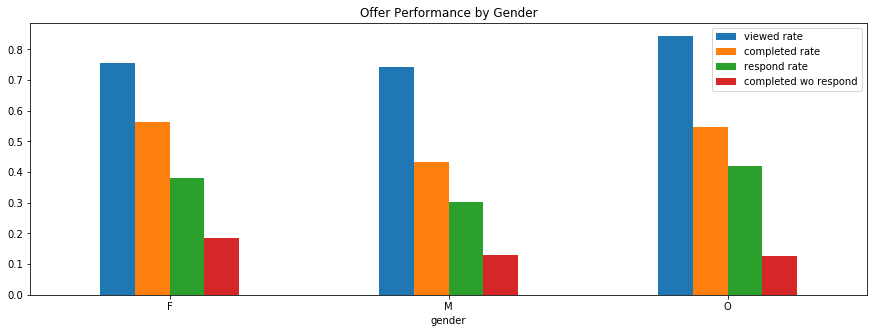

In [247]:
# Groupby gender
offer_rate_gender = df.groupby('gender')[['respond','offer received','offer viewed', 'offer completed']].sum()
offer_rate_gender['viewed rate'] = offer_rate_gender['offer viewed']/offer_rate_gender['offer received']
offer_rate_gender['completed rate'] = offer_rate_gender['offer completed']/offer_rate_gender['offer received']
offer_rate_gender['respond rate'] = offer_rate_gender['respond']/offer_rate_gender['offer received']
offer_rate_gender['completed wo respond'] = offer_rate_gender['completed rate']-offer_rate_gender['respond rate']
offer_rate_gender[['viewed rate', 'completed rate', 'respond rate','completed wo respond']].plot.bar(title='Offer Performance by Gender', figsize=(15,5),rot=0);

In [248]:
offer_rate_gender

,respond,offer received,offer viewed,offer completed,viewed rate,completed rate,respond rate,completed wo respond
gender,,,,,,,,
F,10426.0,27456.0,20786.0,15477.0,0.757066,0.563702,0.379735,0.183967
M,11522.0,38129.0,28301.0,16466.0,0.742243,0.431850,0.302185,0.129665
O,386.0,916.0,773.0,501.0,0.843886,0.546943,0.421397,0.125546


Gender Other has highest viewed rate, completed rate and respond rate. Female have better offer performance than male.

### 1.6 Offer Performance by Age Generation

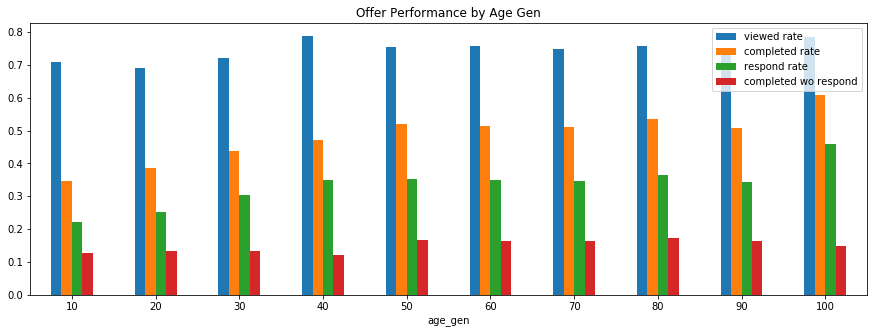

In [249]:
offer_rate_age = df.groupby('age_gen')[['respond','offer received','offer viewed', 'offer completed']].sum()
offer_rate_age['viewed rate'] = offer_rate_age['offer viewed']/offer_rate_age['offer received']
offer_rate_age['completed rate'] = offer_rate_age['offer completed']/offer_rate_age['offer received']
offer_rate_age['respond rate'] = offer_rate_age['respond']/offer_rate_age['offer received']
offer_rate_age['completed wo respond'] = offer_rate_age['completed rate']-offer_rate_age['respond rate']
offer_rate_age[['viewed rate', 'completed rate', 'respond rate','completed wo respond']].plot.bar(title='Offer Performance by Age Gen', figsize=(15,5),rot=0);

In [250]:
offer_rate_age

,respond,offer received,offer viewed,offer completed,viewed rate,completed rate,respond rate,completed wo respond
age_gen,,,,,,,,
10,204.0,921.0,652.0,320.0,0.707926,0.347448,0.221498,0.125950
20,1557.0,6174.0,4261.0,2386.0,0.690152,0.386459,0.252187,0.134273
30,2093.0,6893.0,4976.0,3009.0,0.721892,0.436530,0.303641,0.132888
40,3600.0,10288.0,8111.0,4859.0,0.788394,0.472298,0.349922,0.122376
50,5629.0,15894.0,12008.0,8272.0,0.755505,0.520448,0.354159,0.166289
60,4710.0,13423.0,10172.0,6914.0,0.757804,0.515086,0.350890,0.164196
70,2751.0,7949.0,5946.0,4052.0,0.748019,0.509750,0.346081,0.163668
80,1361.0,3738.0,2833.0,2003.0,0.757892,0.535848,0.364098,0.171750
90,395.0,1147.0,843.0,584.0,0.734961,0.509154,0.344377,0.164778


Respond rate increases from customers with age 20s to those 30s and become very stable from customers with age 40s to 90s. The performance in customers group 100s is the best with highest completed rate and respond rate. This is because the size for age 100s group is very small.

### 1.7 Offer Performance by Age Generation and Gender

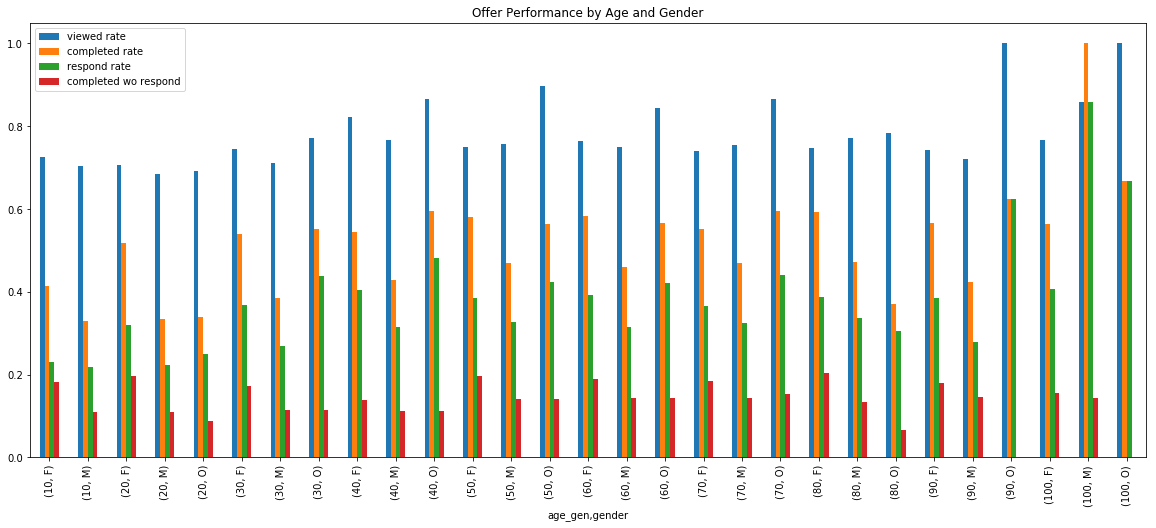

In [251]:
offer_rate_age_gender = df.groupby(['age_gen','gender'])[['respond','offer received','offer viewed', 'offer completed']].sum()
offer_rate_age_gender['viewed rate'] = offer_rate_age_gender['offer viewed']/offer_rate_age_gender['offer received']
offer_rate_age_gender['completed rate'] = offer_rate_age_gender['offer completed']/offer_rate_age_gender['offer received']
offer_rate_age_gender['respond rate'] = offer_rate_age_gender['respond']/offer_rate_age_gender['offer received']
offer_rate_age_gender['completed wo respond'] = offer_rate_age_gender['completed rate']-offer_rate_age_gender['respond rate']
offer_rate_age_gender[['viewed rate', 'completed rate', 'respond rate','completed wo respond']].plot.bar(title='Offer Performance by Age and Gender', figsize=(20,8));

Customers with gender other and aged 40s have highest respond rate except 90s and 100s due to the small sample size.

### 1.8 Average Spending by Income Level

In [252]:
# Create income level by 10000
income_spend = df[['user_id','income','spending','spending wo offer']].drop_duplicates()
income_spend['income_level'] = round(income_spend.income/10000)*10000

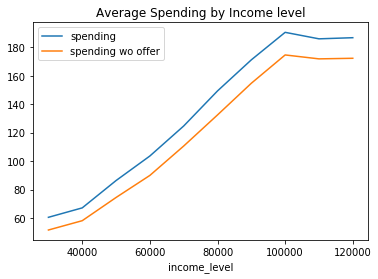

In [288]:
# Plot the line chart
income_spend.groupby('income_level')[['spending','spending wo offer']].mean().plot.line(title='Average Spending by Income level');

The difference between spending and spending without offer remains stable. The weight of spending driven by the offer is decreasing as the income increases. It is common that offer is not sensitive to those with higher income. Let's see the respond rate by income level.

### 1.81 Offer Performance by Income level

In [254]:
# Group df by user_id and append income level column to it
income_offer = df.groupby('user_id')[['respond','offer received','offer viewed', 'offer completed']].sum()
income_offer['income_level'] = income_spend.set_index('user_id')['income_level']

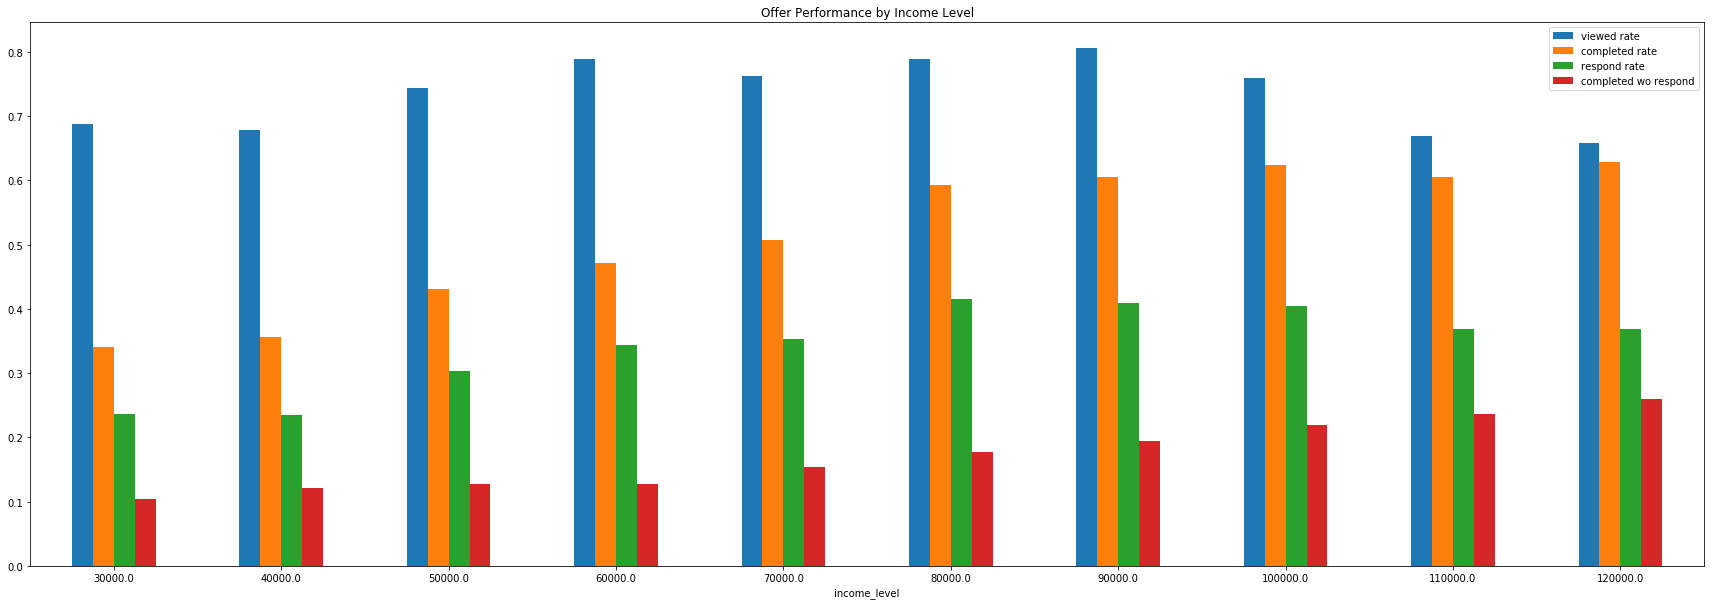

In [255]:
# Plot bar chart for offer performance by income level
income_offer = income_offer.groupby('income_level')[['respond','offer received','offer viewed', 'offer completed']].sum()
income_offer['viewed rate'] = income_offer['offer viewed']/income_offer['offer received']
income_offer['completed rate'] = income_offer['offer completed']/income_offer['offer received']
income_offer['respond rate'] = income_offer['respond']/income_offer['offer received']
income_offer['completed wo respond'] = income_offer['completed rate']-income_offer['respond rate']
income_offer[['viewed rate', 'completed rate', 'respond rate','completed wo respond']].plot.bar(title='Offer Performance by Income Level', figsize=(30,10),rot=0);

It's interesting that respond rate increases until income level reaches $80000. The red bar completed without respond offer keeps increasing as income level increases. This shows that some offers sent to high income customers are unnecessary.  

## 2. Model Implementation
- Build a machine learning model to predict whether a customer will respond the offer based on the offer type and customer demographic

### 2.1 Clean dataset

In [256]:
# Since informational offer has no respond, it has to excluded in the dataset
df_model = df[df.informational==0].copy()

In [257]:
# Since we just need to know whether customers will respond to offer not how many times they will respond, set all value larger than one in column respond to one.
df_model.respond = df_model.respond.apply(lambda x: 1 if x>=1 else 0)

In [258]:
# Get dummies for gender
df_model = pd.get_dummies(df_model, columns=['gender'],prefix='', prefix_sep='')

In [260]:
# Feature email is excluded as all offers use email. No variation for email
X=df_model[['difficulty', 'duration', 'reward', 'mobile', 'social', 'web', 'bogo', 'discount','age','income','member_days','spending wo offer', 'F', 'M', 'O']]

In [261]:
y=df_model['respond'].values

### 2.2 Train and Test Split

In [262]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### 2.21 Scale the data

In [263]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [264]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.3 Random Forests (Baseline) 

In [265]:
from sklearn.ensemble import RandomForestClassifier

In [266]:
clf = RandomForestClassifier(random_state = 42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

#### Model Evaluation
**Metric**: Accuracy is used for model evaluation since the class distribution is similar in the dataset.
<br>
Check the bar chart below

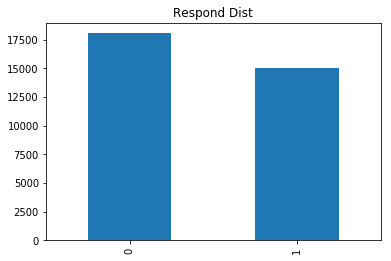

In [267]:
# Plot respond distribution bar chart
pd.DataFrame(np.asarray(np.unique(y_train,return_counts=True)).T).set_index(0).plot.bar(legend=False,
                                                                                        use_index=False,
                                                                                        title="Respond Dist");

In [290]:
print('Accuracy of RF classifier on test set: {:.2f}'.format(clf.score(X_test_scaled, y_test)))

Accuracy of RF classifier on test set: 0.71


### 2.3 Use Pipeline, GridSearchCV and Include Other Classifiers (Refinement)

In [269]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

In [271]:
# Create pipelines for different classifiers
pipe_lr = Pipeline([('scl', scaler), ('LR', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([('scl', scaler), ('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('scl', scaler), ('RF',RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([('scl', scaler), ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('scl', scaler), ('SVM', svm.SVC(random_state=42))])

In [272]:
# Set parameters for gridsearchcv
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [10, 50, 80, 100]

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]

In [273]:
# Use grid search for different classifier
lr_grid_search = GridSearchCV(estimator=pipe_lr, param_grid=lr_param_grid,scoring='accuracy')
dt_grid_search = GridSearchCV(estimator=pipe_dt,param_grid=dt_param_grid,scoring='accuracy')
rf_grid_search = GridSearchCV(estimator=pipe_rf,param_grid=rf_param_grid,scoring='accuracy')
knn_grid_search = GridSearchCV(estimator=pipe_knn,param_grid=knn_param_grid,scoring='accuracy')
svm_grid_search = GridSearchCV(estimator=pipe_svm,param_grid=svm_param_grid,scoring='accuracy')

In [276]:
%%time 
# Run time around 30 mins
# Fit models
grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

CPU times: user 28min 19s, sys: 4.2 s, total: 28min 24s
Wall time: 28min 27s


In [293]:
# Display models' accuracy and models' best parameters
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines'}
clf_name=[]
accu=[]
for i, model in enumerate(grids):
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))
    clf_name.append(grid_dict[i])
    accu.append(model.score(X_test,y_test))
clf_accu = pd.DataFrame.from_dict({'clf_name': clf_name,'accuracy':accu})

Logistic Regression Best Params: {'LR__C': 0.5, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
Decision Trees Best Params: {'DT__criterion': 'entropy', 'DT__max_depth': 6, 'DT__min_samples_leaf': 4, 'DT__min_samples_split': 2}
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}
K-Nearest Neighbors Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5, 'KNN__weights': 'uniform'}
Support Vector Machines Best Params: {'SVM__C': 6, 'SVM__kernel': 'rbf'}


In [294]:
# classifiers accuracy table
clf_accu

,clf_name,accuracy
0,Logistic Regression,0.705595
1,Decision Trees,0.734474
2,Random Forest,0.735017
3,K-Nearest Neighbors,0.697266
4,Support Vector Machines,0.714557


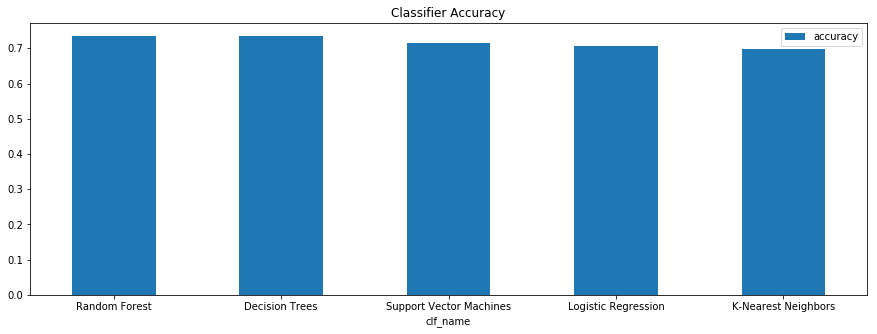

In [279]:
# Plot bar chart for classifier accuracy
clf_accu.sort_values('accuracy',ascending=False).set_index('clf_name').plot.bar(title='Classifier Accuracy', figsize=(15,5),rot=0);

In [280]:
# Plot best classifier's confusion matrix
y_pred = rf_grid_search.predict(X_test)
labels = np.unique(y_pred)
bestcf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

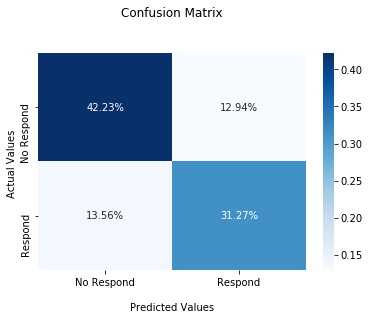

In [281]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(bestcf_matrix/np.sum(bestcf_matrix), annot=True, fmt='.2%',cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels
ax.xaxis.set_ticklabels(['No Respond','Respond'])
ax.yaxis.set_ticklabels(['No Respond','Respond'])

plt.show()

#### Model Evaluation and Validation
Compared to baseline model, ramdom forest is still the best classifier. After using cross validation and grid search for parameters, the accuracy for random forest increases more than 2.5%.  The best parameters for random forest is {'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}
#### Justification
One possible explanation why random forest performs slightly better than other is that creating random subsets of the features and building smaller trees using those subsets can avoid the overfitting. 

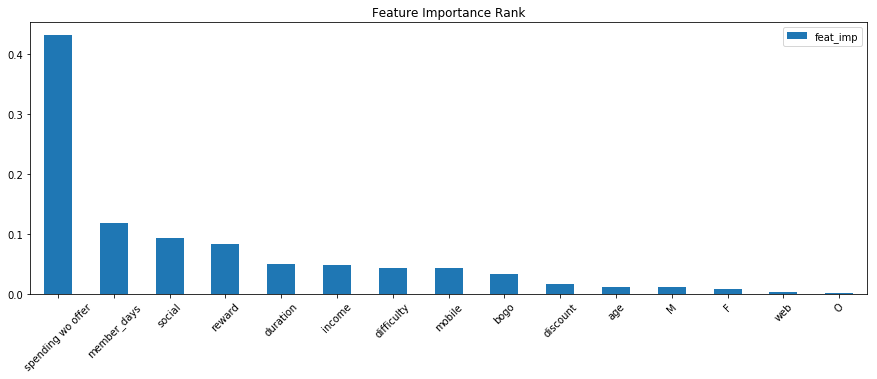

In [282]:
# Create feature importance dataframe
feature_importance = pd.DataFrame(rf_grid_search.best_estimator_.named_steps["RF"].feature_importances_,index=X.columns.tolist(),columns=['feat_imp'])
feature_importance.sort_values('feat_imp',ascending=False,inplace=True)

feature_importance.plot.bar(title='Feature Importance Rank', figsize=(15,5),rot=45);

The top five most important features are:
- spending without offer
- member days
- social
- reward
- duration


## Conclusion
### Reflection
By using random forest model, customers' response can be predicted by their demographics and the offer type. 

The amount of spending without offer and the length of membership are the top two most important factors when customers decide whether to respond the offer.

The social media is the most important channel to deliver offer to customers.

Reward and duration are the fourth and fifth important features. If reward is too low and the duration is too short, it's hard for customers to respond the offer.

One difficulty in this project is to measure the degree of incentives that offers brought to customers. Although I consider that a customer responds the offer if he/she follows the sequence: receive, view and complete offers, some customers' transaction labeled as respond may still be driven by their routine purchasing behavior. In other word, they will buy the coffee anyway with or without offer. 

Another difficulty is to precisely measure the influence of the informational offers. It's hard to tell their influence since the average spending between customers who viewed the offer and who didn't received the offer is minimal. Besides the transaction time and offer duration, no other links are offered to identify the relationship between them. Therefore, informational offers are excluded from the model.

### Improvement
- In current model, I didn't include the frequency of transactions per customers.  This factor can be added to the future improvement. 
- The time of transactions can also be utilized in the future improvement. If a customer transact multiple time, whether transactions happen shortly after he/she views the offer or they happen randomly or equally sparse can tell us the degree of offers' incentive. To realize this feature, the length of the test should be longer.  
- Instead of predicting whether a customer will respond the offer, building an offer recommendation engine can also be an improvement of the project. 